In [ ]:
# package imports
import pandas as pd
import numpy as np
import plotly.express as pe
from pathlib import Path
import sys
import plotly.graph_objects as go
import os
import seaborn as sns
import LESO.defaultvalues as defs
import matplotlib.pyplot as plt
from LESO.experiments.analysis import (
    load_ema_leso_results,
    open_leso_experiment_file,
    quick_lcoe,
    annualized_cost
)

# Folder rooting & defaults

In [2]:
# variables
exp_prefix = "evhub"
run_id = 210907

# rooting
FOLDER = Path(os.path.abspath(''))
RESULT_FOLDER = FOLDER.parent / "results"
sys.path.append(FOLDER.parent.absolute().__str__())

# constants
wind_capex = defs.wind['capex']
pv_capex = defs.pv['capex']
bat_capex = 0.4055 # TODO this is an approximation, since it is not strictly linear due to storage/power components
wind_col = "Nordex N100 2500 installed capacity"
pv_col = "PV South installed capacity"
bat_col = "2h battery installed capacity"

# Extracting data from database and adding relevant coloumns

In [599]:
# extract data
experiments, outcomes, df = load_ema_leso_results(run_id=run_id, exp_prefix=exp_prefix, results_folder=RESULT_FOLDER)
exp = open_leso_experiment_file(RESULT_FOLDER / df.filename_export[0])

# use for defining cols
# for c in df.columns:
#     print(c)
# df.max()

# add cols of interest
df["total_re_capacity"] = df[[wind_col,pv_col]].sum(axis=1)
df["Grid capacity"] = df['grid_capacity'].apply(lambda x : str(x))

# show df
df

,PV South soundwall installed capacity,PV South installed capacity,PV West installed capacity,PV East installed capacity,Nordex N100 2500 installed capacity,Charging demand installed capacity,2h battery installed capacity,6h battery installed capacity,10h battery installed capacity,Grid connection installed capacity,...,battery_cost_factor,pv_cost_factor,wind_cost_factor,grid_capacity,filename_export,solving_time,solver_status,solver_status_code,total_re_capacity,Grid capacity
0,0.000000,15.884143,0.0,0.0,3.259942,20.0,16.117723,0.000000,0.000000,0.5,...,0.644083,0.469872,0.827264,0.5,evhub_exp_777780.json,15.280604,ok,0,19.144085,0.5
2,0.000000,10.226588,0.0,0.0,3.483933,20.0,19.414028,0.000000,0.000000,0.5,...,0.418631,0.488812,0.963015,0.5,evhub_exp_730098.json,21.506376,ok,0,13.710521,0.5
3,0.000000,10.226588,0.0,0.0,3.483933,20.0,19.414028,0.000000,0.000000,0.5,...,0.679636,0.651670,0.778868,0.5,evhub_exp_259791.json,20.375278,ok,0,13.710521,0.5
4,0.025868,10.197474,0.0,0.0,3.484256,20.0,19.416781,0.000000,0.000000,0.5,...,0.478061,0.811394,0.787543,0.5,evhub_exp_102686.json,18.549017,ok,0,13.681730,0.5
5,0.000000,19.570988,0.0,0.0,3.115575,20.0,14.076681,0.000000,0.000000,0.5,...,0.560635,0.423367,0.957718,0.5,evhub_exp_156212.json,19.139893,ok,0,22.686563,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.000000,6.820177,0.0,0.0,0.834390,20.0,3.961189,0.000000,0.000000,1.5,...,0.432240,0.527616,0.873394,1.5,evhub_exp_537943.json,14.988340,ok,0,7.654567,1.5
596,0.000000,7.229379,0.0,0.0,1.555761,20.0,2.524534,0.005781,0.002421,1.5,...,0.641583,0.464155,0.941362,1.5,evhub_exp_185581.json,16.551182,ok,0,8.785140,1.5
597,0.000000,6.753761,0.0,0.0,1.459769,20.0,2.785297,0.000000,0.000000,1.5,...,0.648096,0.573040,0.898404,1.5,evhub_exp_124350.json,13.525833,ok,0,8.213529,1.5
598,0.000000,7.236231,0.0,0.0,1.557232,20.0,2.528902,0.000000,0.000000,1.5,...,0.647788,0.475380,0.919266,1.5,evhub_exp_227895.json,18.103114,ok,0,8.793463,1.5


# KDE and scatterplot for installed capacity vs. cost factor

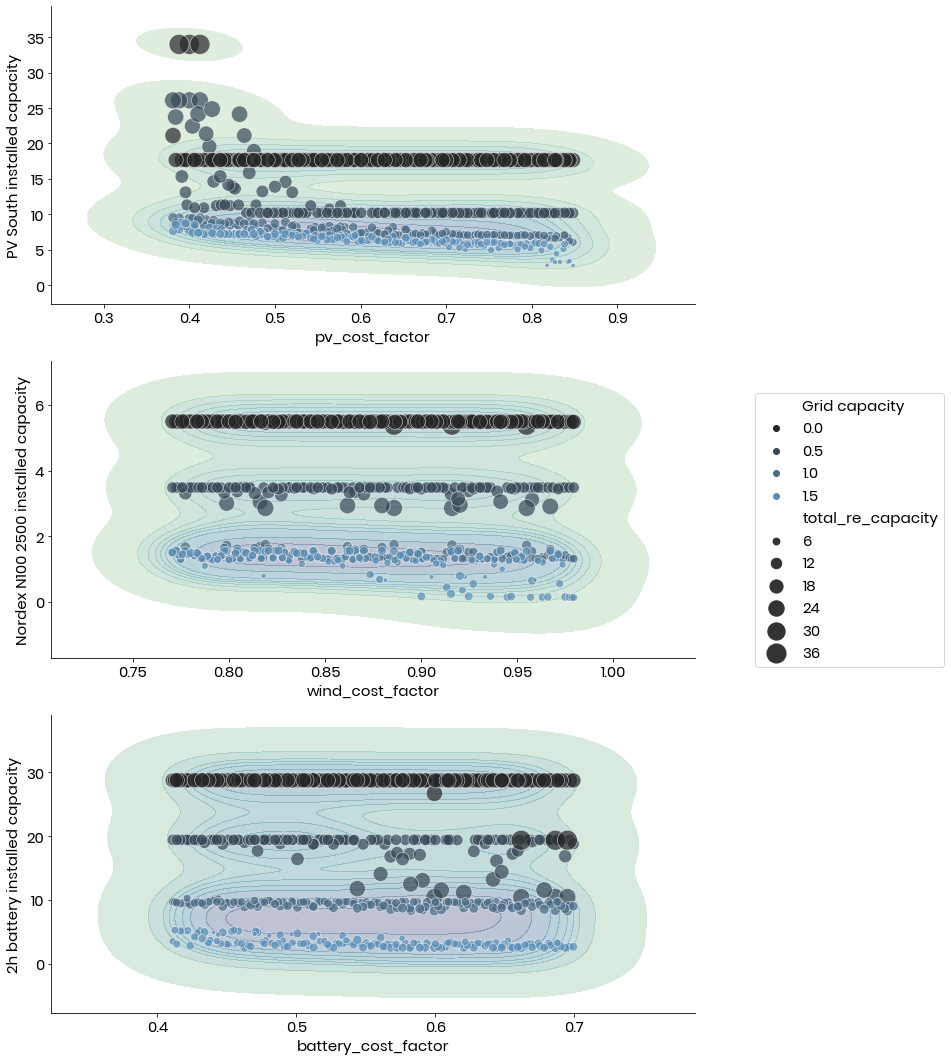

In [598]:
# KDE scatters
fig, axi = plt.subplots(3, 1, figsize=(10, 15))
rc = {
    'font.family':'Poppins',
    'font.size' : 15,
    }
plt.rcParams.update(rc)
hue_order = [str(x) for x in df.grid_capacity.sort_values().unique()]

def scatter_kde(x, y, ax, hue="Grid capacity", size="total_re_capacity"):
    sns.kdeplot(
        data=df,
        x=x,
        y=y,
        fill=True,
        levels=10,
        thresh=0.01,
        cmap="crest",
        alpha=0.3,
        ax=ax,
    )
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        ax=ax,
        size=size,
        alpha=0.7,
        palette="dark:#5b8eb5",
        sizes=(20, 400),
        legend="brief",
    )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# PV
scatter_kde(x="pv_cost_factor", y=pv_col, ax=axi[0])
# wind
scatter_kde(x="wind_cost_factor", y=wind_col, ax=axi[1])
# battery
scatter_kde(x="battery_cost_factor", y=bat_col, ax=axi[2])
# fix the legends
handles, labels = axi[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=[1.05, 0.5])
fig.tight_layout()
# fig.subplots_adjust()


# Installed capacity vs. cost factor at every interconnection level


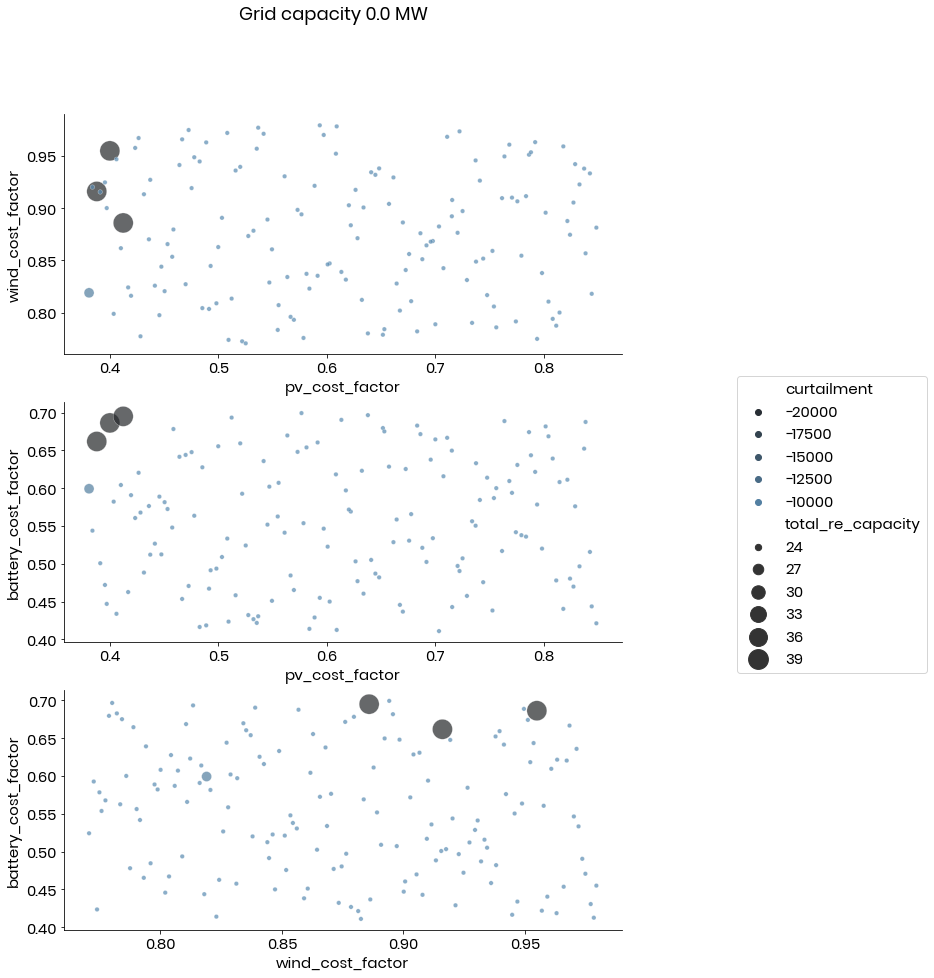

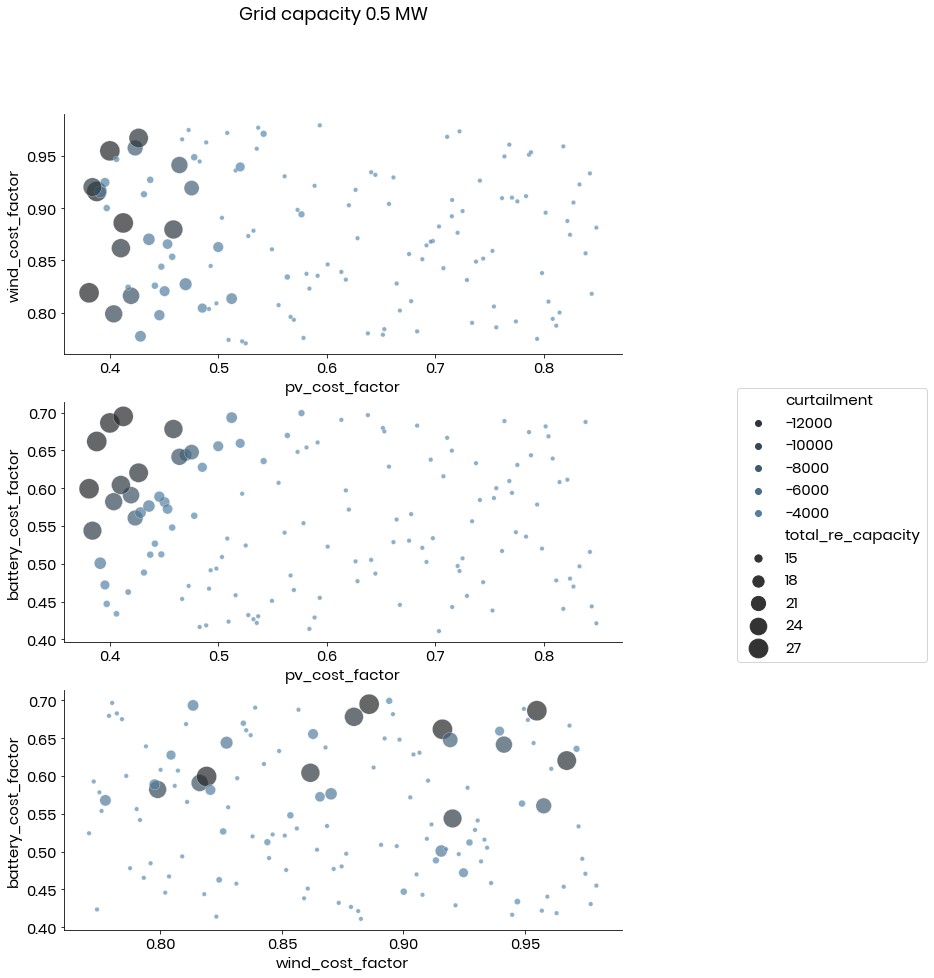

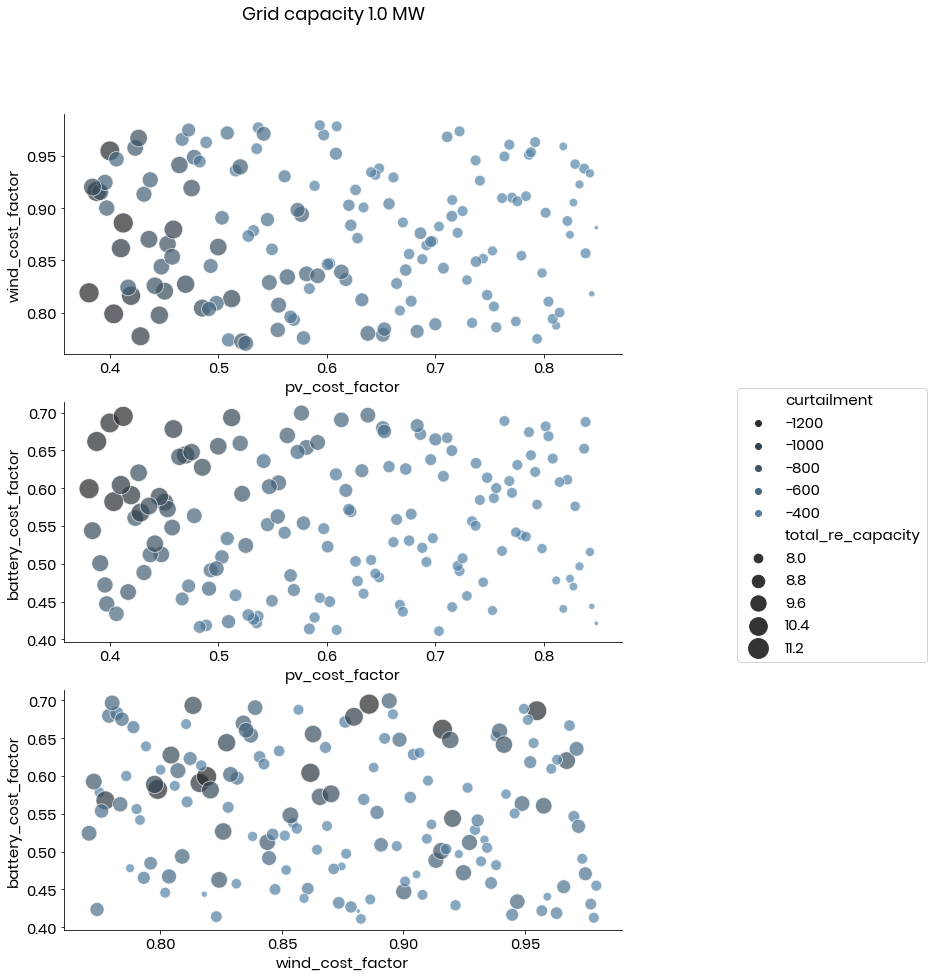

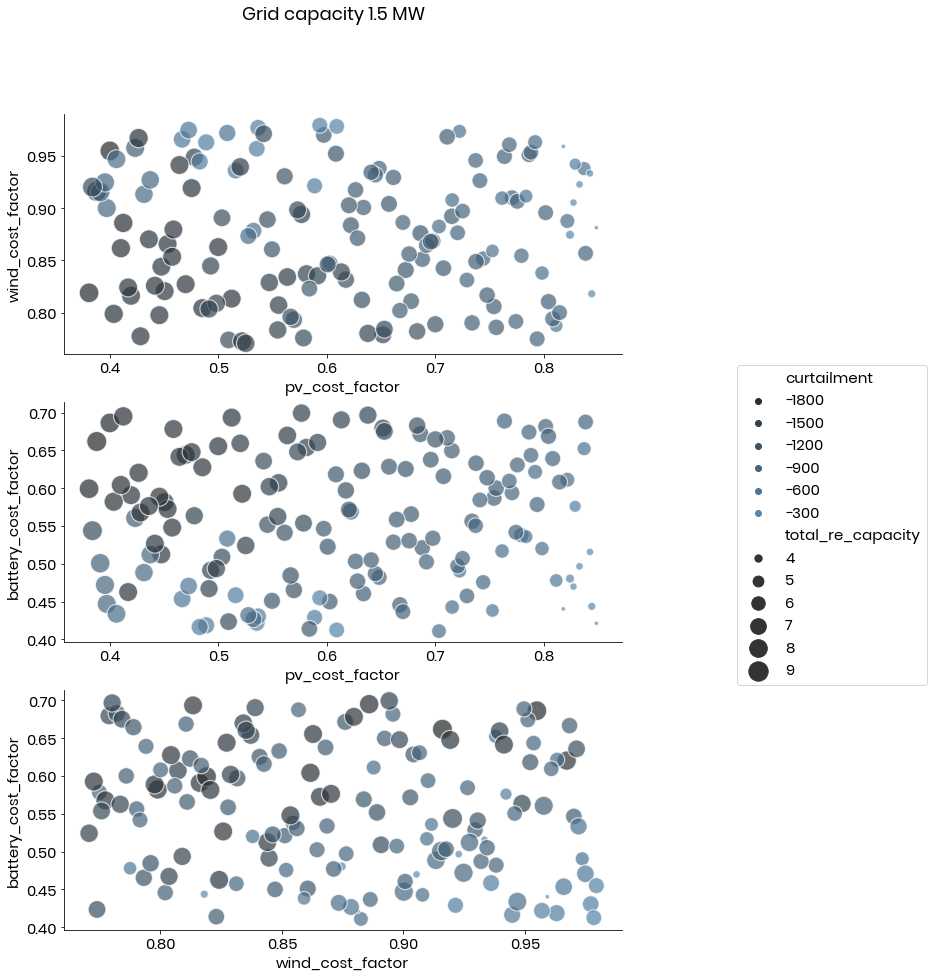

In [573]:
def scatterplot(df, x, y, ax, hue="curtailment", size="total_re_capacity", hue_order=None):
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        ax=ax,
        size=size,
        alpha=0.7,
        palette="dark:#5b8eb5",
        sizes=(20, 400),
        legend="brief",
    )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for grid_cap in hue_order:
    fig, axi = plt.subplots(3, 1, figsize=(10, 15))
    df2 = df[df.grid_capacity== float(grid_cap)]
    # PV vs. Wind
    scatterplot(
        df=df2,
        x="pv_cost_factor",
        y="wind_cost_factor",
        ax=axi[0]
    )
    # PV vs. Bat
    scatterplot(
        df=df2,
        x="pv_cost_factor",
        y="battery_cost_factor",
        ax=axi[1]
    )
    # Wind vs. Bat
    scatterplot(
        df=df2,
        x="wind_cost_factor",
        y="battery_cost_factor",
        ax=axi[2]
    )
    handles, labels = axi[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=[1.05, 0.5])
    fig.suptitle(f"Grid capacity {grid_cap} MW")

# Capacities vs. cost price per component
### > Without the KDE plot
### > Cost factor translated to price per capacity (€/W(h))

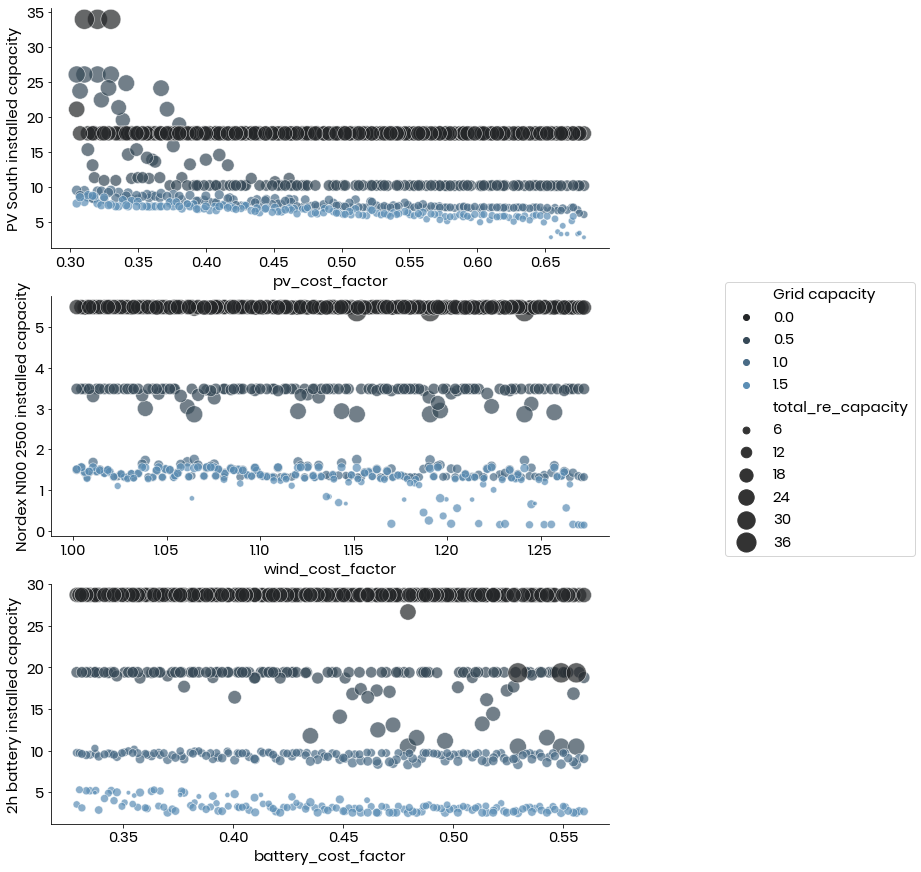

In [590]:
fig, axi = plt.subplots(3, 1, figsize=(10, 15))
    
## PV
scatterplot( 
    df=df,
    x=df["pv_cost_factor"]*pv_capex,
    y=pv_col,
    ax=axi[0],
    hue="Grid capacity",
    hue_order=hue_order,
)

## Wind
scatterplot(
    df=df, 
    x=df["wind_cost_factor"]*wind_capex,
    y=wind_col,
    ax=axi[1],
    hue="Grid capacity",
    hue_order=hue_order,
)
## Battery
scatterplot(
    df=df, 
    x=df["battery_cost_factor"]*pv_capex,
    y=bat_col,
    ax=axi[2],
    hue="Grid capacity",
    hue_order=hue_order,
)

handles, labels = axi[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=[1.05, 0.5])


# Installed capacity pair plots ; discover synergies?

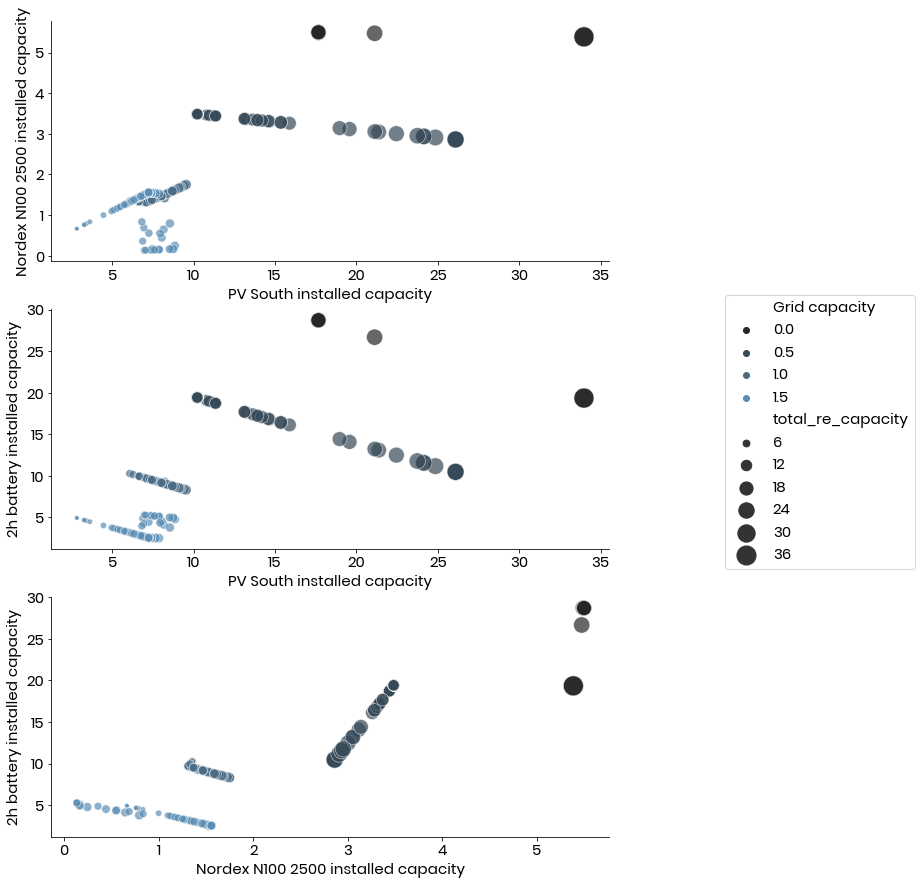

In [601]:
fig, axi = plt.subplots(3, 1, figsize=(10, 15))
    
## PV vs. Wind
scatterplot( 
    df=df,
    x=pv_col,
    y=wind_col,
    ax=axi[0],
    hue="Grid capacity",
    hue_order=hue_order,
)

## PV vs. bat
scatterplot(
    df=df, 
    x=pv_col,
    y=bat_col,
    ax=axi[1],
    hue="Grid capacity",
    hue_order=hue_order,
)
## Wind vs. battery
scatterplot(
    df=df, 
    x=wind_col,
    y=bat_col,
    ax=axi[2],
    hue="Grid capacity",
    hue_order=hue_order,
)

handles, labels = axi[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=[1.05, 0.5])